In [39]:
#라이브러리 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [40]:
#필요한 변수생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [41]:
#파일 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


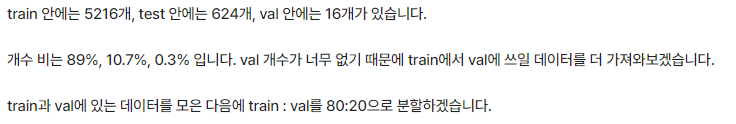

In [42]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [43]:
#정상데이터와 페렴데이터 비율 확인해보기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


Normal images count in training set: 1070
Pneumonia images count in training set: 3115


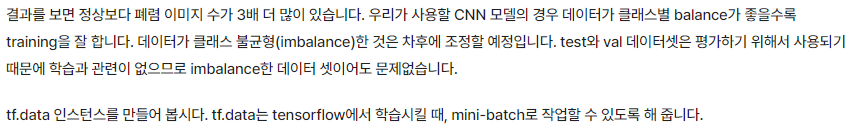

In [44]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [45]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [46]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

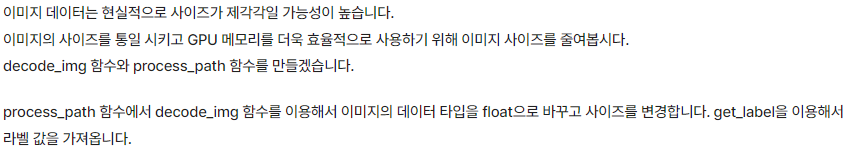

In [47]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#train데이터와val데이터셋을 만든다.(위에정의한 함수로 이미지라벨링을 한후 사이즈조절후 앞서 설정한 변수로인해 메모리효율을 높여주게 map한다.
#AUTOTUNE = tf.data.experimental.AUTOTUNE 코드는 TensorFlow에서 데이터 로딩의 성능을 최적화하기 위한 설정 값입니다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#이미지 리사이즈와 라벨링 잘 되었는지 확인하기
for image, label in train_ds.take(1):#데이터셋중 하나만 가져온다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [48]:
#테스트데이터도 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


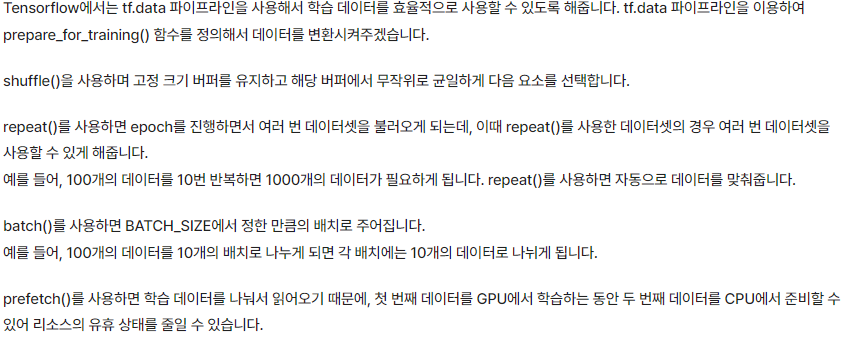

In [49]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

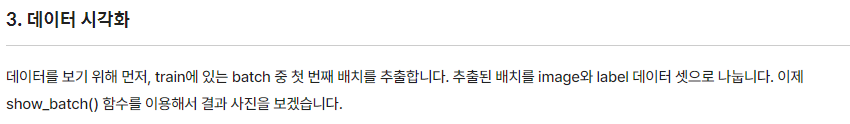

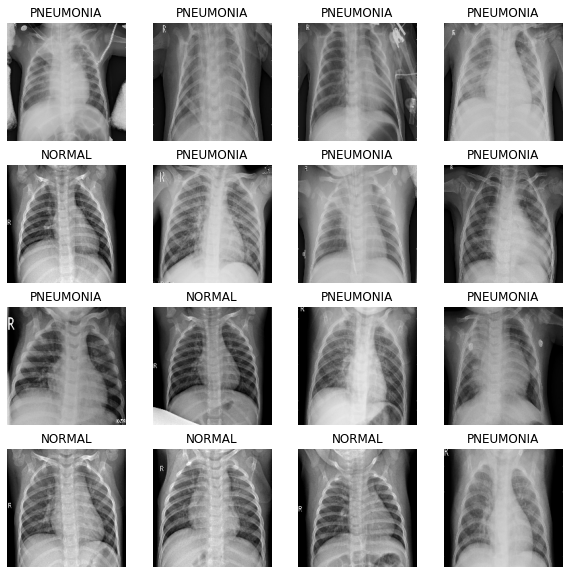

In [13]:
#데이터 시각화 및 전처리한 데이터 확인
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:#앞서 라벨링 한 값에따라 페렴이면 true
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
#진단할 cnn모델링
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block
#dense모델링
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [15]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

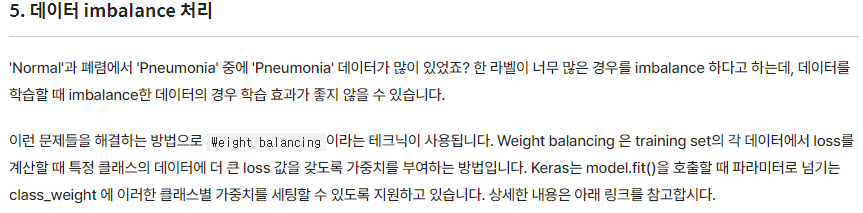

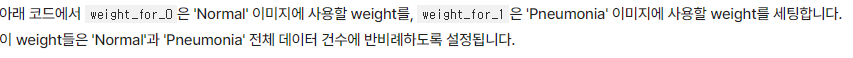

In [16]:
#상대적으로 양성인 페렴인 데이터가 적기때문에 학습시 loss에 음성인 데이터보다 더 적은 가중치를 주기위해 설정.
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [17]:
#이미지 데이터 훈련이기때문에 gpu를 사용하기위해gpu선택
#이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
#성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.
with tf.device('/GPU:0'):
    model = build_model()
#평가지표 설정(변수할당)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [18]:
#모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 70s 215ms/step - loss: 0.4193 - accuracy: 0.7811 - precision: 0.9452 - recall: 0.7494 - val_loss: 0.5981 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 56s 214ms/step - loss: 0.2279 - accuracy: 0.9143 - precision: 0.9778 - recall: 0.9054 - val_loss: 1.4405 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 56s 215ms/step - loss: 0.2014 - accuracy: 0.9239 - precision: 0.9761 - recall: 0.9203 - val_loss: 0.7485 - val_accuracy: 0.7394 - val_precision: 0.7379 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 57s 217ms/step - loss: 0.1795 - accuracy: 0.9332 - precision: 0.9783 - recall: 0.9308 - val_loss: 0.1409 - val_accuracy: 0.9490 - val_precision: 0.9903 - val_recall: 0.9396
Epoch 5/10
261/261 [==============================] - 58s 221ms/step - loss: 0.1686 - accura

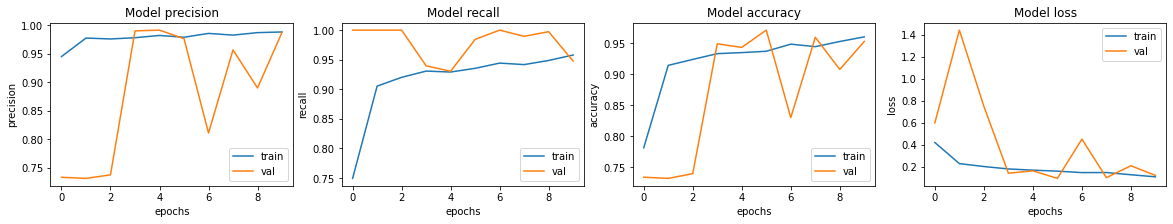

In [19]:
#결과확인 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.5951 - accuracy: 0.8141 - precision: 0.7866 - recall: 0.9641
Loss: 0.595067024230957,
Accuracy: 0.8141025900840759,
Precision: 0.7866109013557434,
Recall: 0.964102566242218


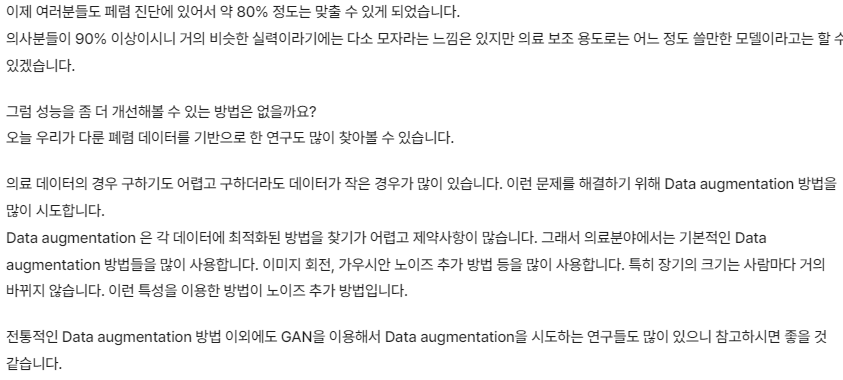

## 프로젝트:폐렴진단기 성능개선

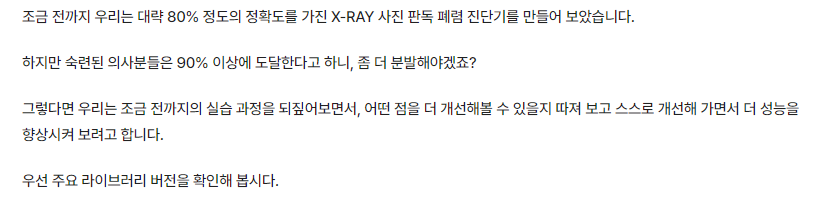

In [3]:
#라이브러리 버전확인
import tensorflow

print(tensorflow.__version__)


2.6.0


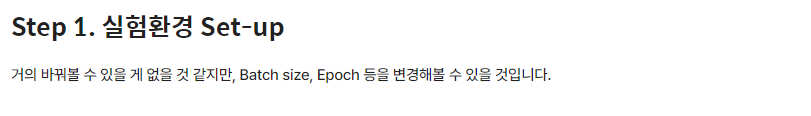

In [4]:
#라이브러리 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
#필요한 변수생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16 #처음에 학습속도와 효율을 높이기위해 batch사이즈를 32로 늘렸더니 컴퓨터가 버티지못하고 메모리 문제가떠서 결국 16으로 맞추었다..ㅜ
EPOCHS = 10#에폭은 늘릴수록 오히려 모델이 데이터에 팅기거나 평가지표들이 너무불안정하여 10으로 그대로 고정하였다.

print(ROOT_PATH)

/aiffel/aiffel


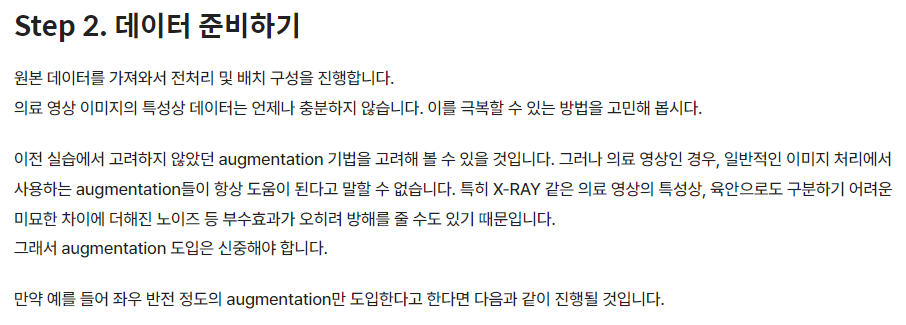

In [5]:
#파일 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

#정상데이터와 페렴데이터 비율 확인해보기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#train데이터와val데이터셋을 만든다.(위에정의한 함수로 이미지라벨링을 한후 사이즈조절후 앞서 설정한 변수로인해 메모리효율을 높여주게 map한다.
#AUTOTUNE = tf.data.experimental.AUTOTUNE 코드는 TensorFlow에서 데이터 로딩의 성능을 최적화하기 위한 설정 값입니다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#이미지 리사이즈와 라벨링 잘 되었는지 확인하기
for image, label in train_ds.take(1):#데이터셋중 하나만 가져온다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
    #테스트데이터도 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


# data augumentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


5216
624
16
4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  False
624


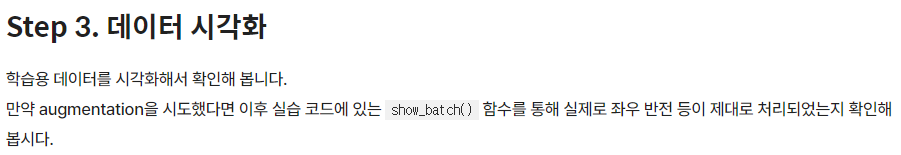

Image shape:  (180, 180, 3)
Label:  False


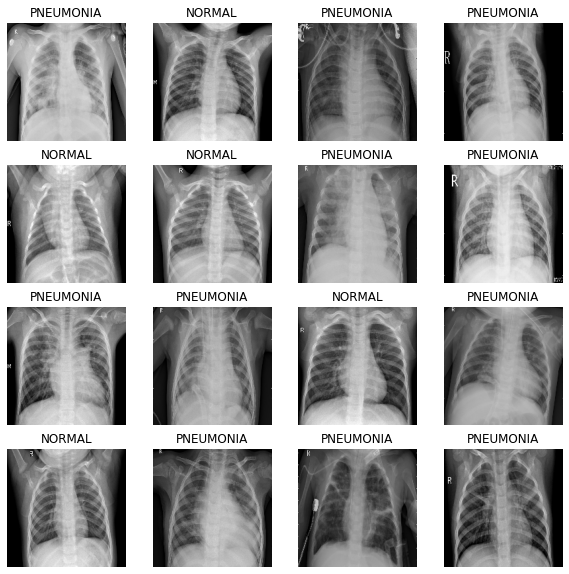

In [6]:
#데이터 시각화 및 전처리한 데이터 확인
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#train데이터와val데이터셋을 만든다.(위에정의한 함수로 이미지라벨링을 한후 사이즈조절후 앞서 설정한 변수로인해 메모리효율을 높여주게 map한다.
#AUTOTUNE = tf.data.experimental.AUTOTUNE 코드는 TensorFlow에서 데이터 로딩의 성능을 최적화하기 위한 설정 값입니다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#이미지 리사이즈와 라벨링 잘 되었는지 확인하기
for image, label in train_ds.take(1):#데이터셋중 하나만 가져온다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:#앞서 라벨링 한 값에따라 페렴이면 true
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

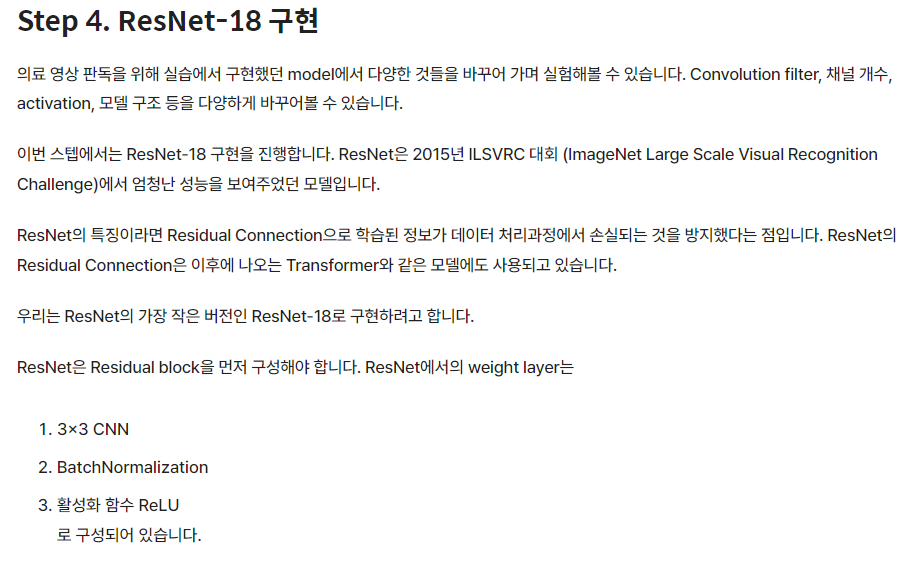

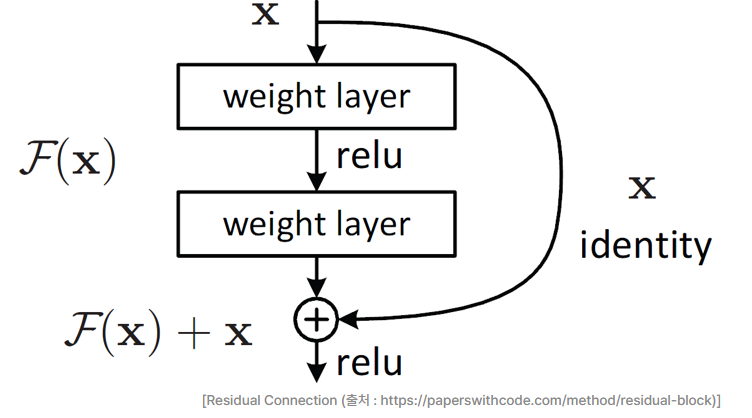

In [77]:
#진단할 resnet모델링
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, ReLU, Add
from tensorflow.keras.initializers import HeNormal

def conv2d_bn(x, filters, kernel_size, strides, kernel_initializer, kernel_regularizer):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', 
               kernel_initializer=kernel_initializer,
               kernel_regularizer=kernel_regularizer)(x)
    x = BatchNormalization()(x)
    return x

def conv2d_bn_relu(x, filters, kernel_size, strides, kernel_initializer, kernel_regularizer):
    x = conv2d_bn(x, filters, kernel_size, strides, kernel_initializer, kernel_regularizer)
    x = Activation('relu')(x)
    return x

# ResidualBlock 함수를 정의합니다.
def ResidualBlock(x, filters, kernel_size, kernel_initializer, kernel_regularizer, downsample=False):
    shortcut = x
    if downsample:
        shortcut = conv2d_bn(x, filters, kernel_size=1, strides=2, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
        strides = 2
    else:
        strides = 1

    x = conv2d_bn_relu(x, filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
    x = conv2d_bn(x, filters, kernel_size, strides=1, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)

    # Add() 레이어를 사용하여 shortcut connection을 구현합니다.
    out = Add()([shortcut, x])
    out = Activation('relu')(out)
    return out


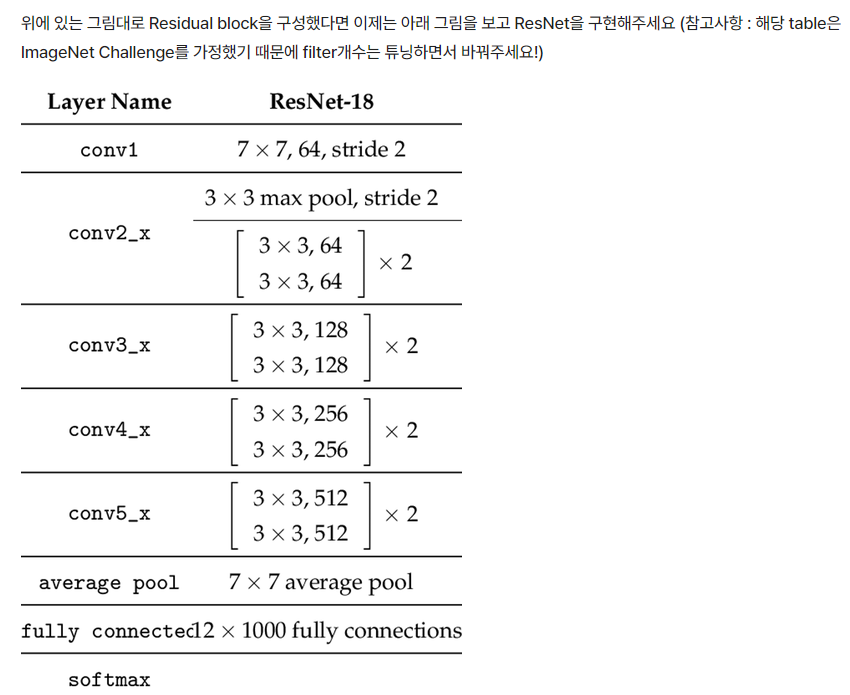

In [102]:
#resnet모델만들기
import tensorflow as tf
from tensorflow.keras.layers import Input, AveragePooling2D,Flatten,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
def ResNet18(classes, input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, (7,7), strides=2, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(inputs)
    max_pooling = MaxPooling2D(3, strides=2, padding='same')(conv1)
    
    conv2_x = ResidualBlock(max_pooling, 64, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=False)
    conv2_x = ResidualBlock(conv2_x, 64, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=False)

    conv3_x = ResidualBlock(conv2_x, 128, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=True)
    conv3_x = ResidualBlock(conv3_x, 128, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=False)

    conv4_x = ResidualBlock(conv3_x, 256, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=True)
    conv4_x = ResidualBlock(conv4_x, 256, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=False)

    conv5_x = ResidualBlock(conv4_x, 512, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=True)
    conv5_x = ResidualBlock(conv5_x, 512, kernel_size=(3,3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), downsample=False)

    x = GlobalAveragePooling2D()(conv5_x)
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
    x = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
    out_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=out_layer)
    return model

#input_shape = tf.keras.layers.Input(shape=(180, 180, 3))
# model = build_resnet(input_tensor, num_classes=2)

# #input layer와 residual module을 연결해서 모델을 만듭니다.
# model = keras.models.Model(inputs=input, outputs=output)
# model.summary()
# # model = build_resnet(input_shape=(180, 180, 3), num_classes=2)


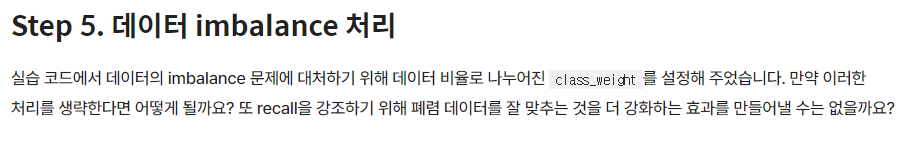

In [103]:
#상대적으로 양성인 페렴인 데이터가 적기때문에 학습시 loss에 음성인 데이터보다 더 적은 가중치를 주기위해 설정.
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))



Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


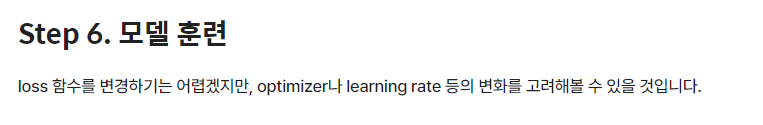

In [104]:
#이미지 데이터 훈련이기때문에 gpu를 사용하기위해gpu선택
#이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
#성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.
from tensorflow.keras.mixed_precision import experimental as mixed_precision#GPU메모리가 부족하여 16비트 정밀도 사용: 가능하다면 16비트 부동소수점(float16) 연산을 사용하여 메모리 사용량을 크게 줄일 수 있습니다. 최신의 많은 GPU는 16비트 연산을 지원하며, 이를 통해 메모리 사용량과 연산 시간을 줄일 수 있습니다.
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

with tf.device('/GPU:0'):
    model = ResNet18(classes=2, input_shape=(180, 180, 3))

#평가지표 설정(변수할당)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [105]:
#모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 70s 201ms/step - loss: 17.6692 - accuracy: 0.8666 - precision: 0.9590 - recall: 0.8574 - val_loss: 3.2081 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 198ms/step - loss: 1.6694 - accuracy: 0.8645 - precision: 0.9612 - recall: 0.8523 - val_loss: 21.5393 - val_accuracy: 0.3144 - val_precision: 1.0000 - val_recall: 0.0655
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.8676 - accuracy: 0.8714 - precision: 0.9626 - recall: 0.8607 - val_loss: 1.1897 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.7782 - accuracy: 0.8537 - precision: 0.9650 - recall: 0.8339 - val_loss: 1.0580 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 53s 203ms/step - loss: 0.7341 - accu

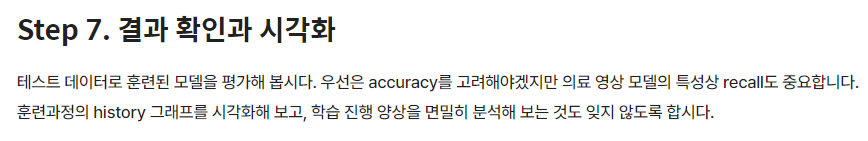

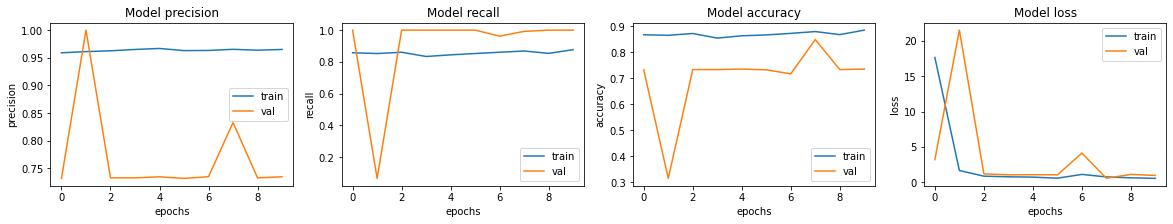

In [106]:
#결과확인 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

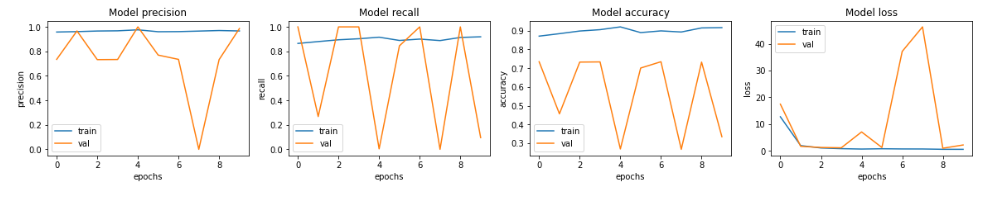

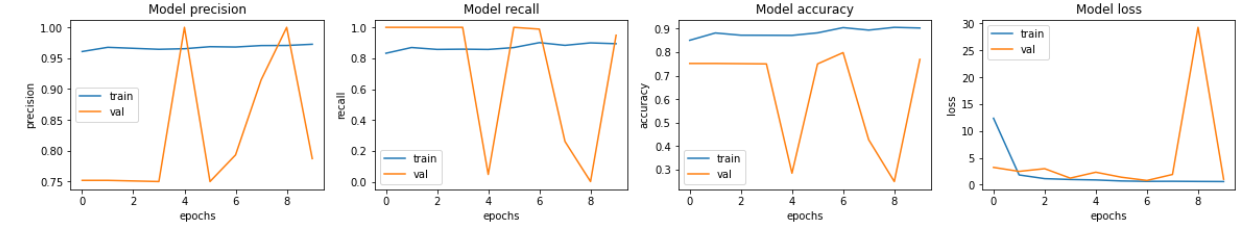

In [107]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


39/39 [==============================] - 5s 117ms/step - loss: 1.2152 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.2152135372161865,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


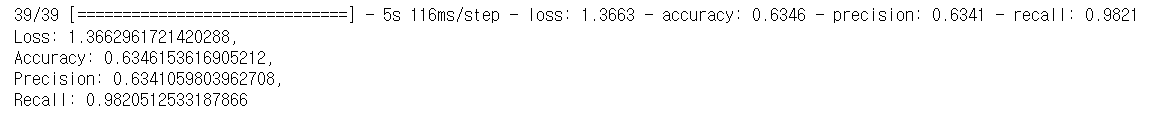

## 회고
- k:이론으로는 이해가가지만 코드짜는게 아직어렵도 서툴고 너무 복잡해서 활용이 잘 안되었다. 모델을 처음부터 직접짜는게 생각보다 어렵고 오류도 많이 생긴다는것을 알았다.중간에 포기하고싶었지만 어떻게든 실습코드와 구글링,gpt를 통해 해결하였다. 끝까지 resnet모델을 구현하여 학습시켜봤다는것이 잘한거같다.

- p:resnet구조를 안다고생각했는대 생각보다 구현도 안되고 코드도 서툴러서 시간을 많이뺐겼다. 학습하고 평가지표를 비교해가면서 모델의 성능을 높이는대 시간을 많이 투자해서 높이고싶었지만 모델학습하는대 시간이 오래걸려 그러지못한것이 아쉽다. 모델이 학습데이터에서는 일정하고 높은 평가지표를 보이고있지만 검증데이터셋에서 너무 불안정하고 튀기는 경향이있다. 

- t:이론은 어느정도 안다고 생각했는대 코드로 구현을 못하니 완전히 알고있지 않다는것과 더 배우고 공부해야될것이 많다는것을 알게되었다. 주말에 모델의 성능도 높여보고 이론도 다시공부해서 다른방식으로 모델도구현해보고 resnet말고 다른모델도 스스로 구현해봐야 할것같다.